In [3]:
import pandas as pd
import numpy as np
import nltk
import nltk.sentiment.util
import matplotlib.pyplot as plt
import pprint
import re
import gensim
import gensim.corpora as corpora
import os
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

In [4]:
df = pd.read_csv("../../amazon_reviews_us_Grocery_v1_00.tsv", sep='\t', quoting=3)
df = df[["product_id", "star_rating", "review_headline"]]
df

,product_id,star_rating,review_headline
0,B000SAQCWC,5,Using these for years - love them.
1,B00509LVIQ,5,Wonderful
2,B00KHXESLC,5,Five Stars
3,B000F8JIIC,5,Five Stars
4,B004ZWR9RQ,5,Five Stars
...,...,...,...
2402453,B00004TBB0,4,Different
2402454,B00000K1X9,5,This Horse Is Gorgourges!
2402455,B00000K1X9,5,"brilliant, realistic model!"
2402456,B00000K1X9,5,don't have it yet..but will soon


In [5]:
data = df.dropna()
data = data.query('star_rating < 4', engine='python')
data = data.sample(100000)
data

,product_id,star_rating,review_headline
2364171,B0000CFLCQ,1,12 packs not shipped correctly.
2321598,B000FFLXME,3,Bread:
887080,B0043ZFIOG,3,They're Okay
1976917,B003WEC4RS,1,Not as depicted on Amazon is 2.0 model
1608654,B00CSSTZPI,3,its okay
...,...,...,...
2156602,B0019RLJV2,1,Do not buy food from amazon. This has been sit...
2271436,B00246FOGS,1,Way too sweet!
1869414,B001P7AZN4,1,Terrible After Tase
1970762,B005XLDNH8,2,Disappointed


In [6]:
#data['review_body'] = data['review_body'].map(lambda x: re.sub('[,\.!?]', '', x))
#data['review_body'] = data['review_body'].map(lambda x: x.lower())
data = data["review_headline"]
data

2364171                      12 packs not shipped correctly.
2321598                                               Bread:
887080                                          They're Okay
1976917               Not as depicted on Amazon is 2.0 model
1608654                                             its okay
                                 ...                        
2156602    Do not buy food from amazon. This has been sit...
2271436                                       Way too sweet!
1869414                                  Terrible After Tase
1970762                                         Disappointed
1209375                            Overhyped.  Not worth it.
Name: review_headline, Length: 100000, dtype: object

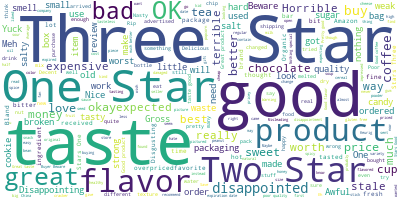

In [7]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(data.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [8]:
stop_words = stopwords.words('english')
stop_words.extend(['br','[', ',', '\\', '.', '!', '?', ']', '<', '>', '$', '£', '/', '*', '(', ')', '%', '^', '&', '-', '_', '=', '+', '|', '#','~',';',':','...',"''",'//','\\\\',"n't","'ve","'m","'s"])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(nltk.word_tokenize(str(sentence)))
        
def remove_stopwords(texts):
    return [[(te,ta) for (te,ta) in doc if (te.replace("_NEG","") not in stop_words)] for doc in texts]

data_filtered = data
data_words = list(sent_to_words(data_filtered))
# remove stop words
#data_words = remove_stopwords(data_words)
pprint.pprint(data_words[:5])
#np.array(data_words[0], dtype=object).shape

[['12', 'packs', 'not', 'shipped', 'correctly', '.'],
 ['Bread', ':'],
 ['They', "'re", 'Okay'],
 ['Not', 'as', 'depicted', 'on', 'Amazon', 'is', '2.0', 'model'],
 ['its', 'okay']]


In [9]:
data_words = [[word.lower() for word in data_point] for data_point in data_words]
data_words

[['12', 'packs', 'not', 'shipped', 'correctly', '.'],
 ['bread', ':'],
 ['they', "'re", 'okay'],
 ['not', 'as', 'depicted', 'on', 'amazon', 'is', '2.0', 'model'],
 ['its', 'okay'],
 ['one', 'star'],
 ['poor', 'texture'],
 ['stale', 'and', 'hard', '!'],
 ['not', 'terrible', '...', 'but', 'not', 'good', 'either'],
 ['as', 'i', 'can', 'see', 'it', 'was', 'a', 'waste', 'of', 'my', 'money'],
 ['yeah',
  ',',
  'i',
  'have',
  'to',
  'agree',
  'with',
  'the',
  'negative',
  'reviews'],
 ['the',
  'candy',
  'had',
  'expired',
  'the',
  'month',
  'before',
  'and',
  'was',
  'all',
  '...'],
 ['tasty', 'but', 'spicy'],
 ['sent', 'fat', 'free'],
 ['you', 'evil', 'price', 'gouger', '!', '!', '!'],
 ['i', 'want', 'a', 'replacment', 'not', 'a', 'refund'],
 ['rancid', 'and', 'unsable'],
 ['one', 'star'],
 ['three', 'stars'],
 ['three', 'stars'],
 ['good', 'try'],
 ['good', 'syrup'],
 ['hard', ',', 'stale'],
 ['one', 'star'],
 ['they', 'are', '``', 'ok', "''", '.......', '...'],
 ['worth',

In [10]:
import nltk.sentiment.util
tokens = list(map(nltk.word_tokenize, data))
negated_tokens = list(map(nltk.sentiment.util.mark_negation, tokens))
data = negated_tokens

In [11]:
#print(data_words)
def tag(texts):
    #tokens = list(map(nltk.word_tokenize, texts))
    tagged = [nltk.pos_tag(text, tagset='universal') for text in texts]
    negated_tokens = list(map(nltk.sentiment.util.mark_negation, texts))
    negated_tagged = [[(negated_tokens[i][j], tagged[i][j][1]) for j in range(len(texts[i]))] for i in range(len(texts))]
    return negated_tagged
negated_tagged = tag(data_words)
negated_tagged

[[('12', 'NUM'),
  ('packs', 'NOUN'),
  ('not', 'ADV'),
  ('shipped_NEG', 'VERB'),
  ('correctly_NEG', 'ADV'),
  ('.', '.')],
 [('bread', 'NOUN'), (':', '.')],
 [('they', 'PRON'), ("'re", 'VERB'), ('okay', 'ADJ')],
 [('not', 'ADV'),
  ('as_NEG', 'ADV'),
  ('depicted_NEG', 'VERB'),
  ('on_NEG', 'ADP'),
  ('amazon_NEG', 'NOUN'),
  ('is_NEG', 'VERB'),
  ('2.0_NEG', 'NUM'),
  ('model_NEG', 'NOUN')],
 [('its', 'PRON'), ('okay', 'NOUN')],
 [('one', 'NUM'), ('star', 'NOUN')],
 [('poor', 'ADJ'), ('texture', 'NOUN')],
 [('stale', 'NOUN'), ('and', 'CONJ'), ('hard', 'ADJ'), ('!', '.')],
 [('not', 'ADV'),
  ('terrible_NEG', 'ADJ'),
  ('..._NEG', '.'),
  ('but_NEG', 'CONJ'),
  ('not_NEG', 'ADV'),
  ('good_NEG', 'ADJ'),
  ('either_NEG', 'CONJ')],
 [('as', 'ADP'),
  ('i', 'NOUN'),
  ('can', 'VERB'),
  ('see', 'VERB'),
  ('it', 'PRON'),
  ('was', 'VERB'),
  ('a', 'DET'),
  ('waste', 'NOUN'),
  ('of', 'ADP'),
  ('my', 'PRON'),
  ('money', 'NOUN')],
 [('yeah', 'NOUN'),
  (',', '.'),
  ('i', 'NOUN'),
  (

In [12]:
data_words = remove_stopwords(negated_tagged)
data_words

[[('12', 'NUM'),
  ('packs', 'NOUN'),
  ('shipped_NEG', 'VERB'),
  ('correctly_NEG', 'ADV')],
 [('bread', 'NOUN')],
 [("'re", 'VERB'), ('okay', 'ADJ')],
 [('depicted_NEG', 'VERB'),
  ('amazon_NEG', 'NOUN'),
  ('2.0_NEG', 'NUM'),
  ('model_NEG', 'NOUN')],
 [('okay', 'NOUN')],
 [('one', 'NUM'), ('star', 'NOUN')],
 [('poor', 'ADJ'), ('texture', 'NOUN')],
 [('stale', 'NOUN'), ('hard', 'ADJ')],
 [('terrible_NEG', 'ADJ'), ('good_NEG', 'ADJ'), ('either_NEG', 'CONJ')],
 [('see', 'VERB'), ('waste', 'NOUN'), ('money', 'NOUN')],
 [('yeah', 'NOUN'),
  ('agree', 'VERB'),
  ('negative', 'ADJ'),
  ('reviews', 'NOUN')],
 [('candy', 'NOUN'), ('expired', 'VERB'), ('month', 'NOUN')],
 [('tasty', 'NOUN'), ('spicy', 'NOUN')],
 [('sent', 'NOUN'), ('fat', 'NOUN'), ('free', 'ADJ')],
 [('evil', 'VERB'), ('price', 'NOUN'), ('gouger', 'NOUN')],
 [('want', 'VERB'), ('replacment', 'NOUN'), ('refund_NEG', 'NOUN')],
 [('rancid', 'NOUN'), ('unsable', 'ADJ')],
 [('one', 'NUM'), ('star', 'NOUN')],
 [('three', 'NUM'), (

In [13]:
#gets adjectives

def get_adjectives(tagged):
    review_a = [word for (word, tag) in tagged if (tag == 'ADJ' or tag == 'ADV' or tag == 'NOUN' or tag == 'VERB')]
    return review_a

data_words = list(map(lambda x: get_adjectives(x), data_words))

'''
for i in range(len(data_words)):
    data_words[i] = [word for (word,tag) in data_words[i]]
'''
data_words


[['packs', 'shipped_NEG', 'correctly_NEG'],
 ['bread'],
 ["'re", 'okay'],
 ['depicted_NEG', 'amazon_NEG', 'model_NEG'],
 ['okay'],
 ['star'],
 ['poor', 'texture'],
 ['stale', 'hard'],
 ['terrible_NEG', 'good_NEG'],
 ['see', 'waste', 'money'],
 ['yeah', 'agree', 'negative', 'reviews'],
 ['candy', 'expired', 'month'],
 ['tasty', 'spicy'],
 ['sent', 'fat', 'free'],
 ['evil', 'price', 'gouger'],
 ['want', 'replacment', 'refund_NEG'],
 ['rancid', 'unsable'],
 ['star'],
 ['stars'],
 ['stars'],
 ['good', 'try'],
 ['good', 'syrup'],
 ['hard', 'stale'],
 ['star'],
 ['ok', '.......'],
 ['worth', 'try'],
 ['crushed', 'mystery', 'flavors'],
 ['extremely', 'hot', 'stomach', 'ache'],
 ['expected_NEG'],
 ['valentine', 'gift'],
 ['ok'],
 ['stars'],
 ['stars'],
 ['simply', 'wasted', 'money', 'used', 'order', 'real'],
 ['smashed', 'cookies'],
 ['clumpy', 'grainy'],
 ['like_NEG'],
 ['please',
  'read',
  'disclaimer',
  'beginning',
  'review',
  'amazon',
  'combining',
  'reviews',
  'several',
  'prod

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
pprint.pprint(corpus[:5])

[[(0, 1), (1, 1), (2, 1)],
 [(3, 1)],
 [(4, 1), (5, 1)],
 [(6, 1), (7, 1), (8, 1)],
 [(5, 1)]]


In [15]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       minimum_probability=0.1,
                                       workers=3,
                                       passes=2)
# Print the Keyword in the 10 topics
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"stale" + 0.032*"really" + 0.031*"awful" + 0.026*"nothing" + '
  '0.017*"nice" + 0.017*"taste" + 0.015*"like" + 0.014*"old" + 0.014*"arrived" '
  '+ 0.012*"contains"'),
 (1,
  '0.067*"disappointed" + 0.061*"flavor" + 0.030*"poor" + 0.023*"bad" + '
  '0.022*"candy" + 0.019*"quality" + 0.015*"fine" + 0.013*"dry" + '
  '0.011*"package" + 0.011*"packaging"'),
 (2,
  '0.088*"good_NEG" + 0.079*"ok" + 0.049*"taste_NEG" + 0.045*"buy_NEG" + '
  '0.032*"horrible" + 0.021*"money" + 0.018*"salty" + 0.015*"disgusting" + '
  '0.013*"waste" + 0.012*"product_NEG"'),
 (3,
  '0.033*"expected_NEG" + 0.023*"small" + 0.017*"would" + 0.015*"water" + '
  '0.014*"tasty" + 0.013*"fresh_NEG" + 0.012*"hard" + 0.012*"coconut" + '
  '0.012*"favorite_NEG" + 0.011*"made"'),
 (4,
  '0.053*"coffee" + 0.043*"okay" + 0.038*"good" + 0.038*"tea" + '
  '0.022*"flavor_NEG" + 0.021*"price" + 0.018*"bad_NEG" + 0.016*"meh" + '
  '0.015*"bland" + 0.013*"taste"'),
 (5,
  '0.369*"stars" + 0.028*"weak" + 0.020*"work_

In [16]:
pprint.pprint(lda_model.print_topics(num_topics=100))

[(0,
  '0.040*"stale" + 0.032*"really" + 0.031*"awful" + 0.026*"nothing" + '
  '0.017*"nice" + 0.017*"taste" + 0.015*"like" + 0.014*"old" + 0.014*"arrived" '
  '+ 0.012*"contains"'),
 (1,
  '0.067*"disappointed" + 0.061*"flavor" + 0.030*"poor" + 0.023*"bad" + '
  '0.022*"candy" + 0.019*"quality" + 0.015*"fine" + 0.013*"dry" + '
  '0.011*"package" + 0.011*"packaging"'),
 (2,
  '0.088*"good_NEG" + 0.079*"ok" + 0.049*"taste_NEG" + 0.045*"buy_NEG" + '
  '0.032*"horrible" + 0.021*"money" + 0.018*"salty" + 0.015*"disgusting" + '
  '0.013*"waste" + 0.012*"product_NEG"'),
 (3,
  '0.033*"expected_NEG" + 0.023*"small" + 0.017*"would" + 0.015*"water" + '
  '0.014*"tasty" + 0.013*"fresh_NEG" + 0.012*"hard" + 0.012*"coconut" + '
  '0.012*"favorite_NEG" + 0.011*"made"'),
 (4,
  '0.053*"coffee" + 0.043*"okay" + 0.038*"good" + 0.038*"tea" + '
  '0.022*"flavor_NEG" + 0.021*"price" + 0.018*"bad_NEG" + 0.016*"meh" + '
  '0.015*"bland" + 0.013*"taste"'),
 (5,
  '0.369*"stars" + 0.028*"weak" + 0.020*"work_

In [17]:
from itertools import chain
lda_corpus = lda_model[corpus]

# Find the threshold, let's set the threshold to be 1/#clusters,
# To prove that the threshold is sane, we average the sum of all probabilities:
scores = list(chain(*[[score for topic_id,score in topic] for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)


In [18]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models
data_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

pyLDAvis.display(data_vis)

In [ ]:
print(threshold)

In [43]:
'''cluster1 = [j for i,j in zip(lda_corpus[:100],texts[:100]) if i[0][1] > threshold]
print(1)
cluster2 = [j for i,j in zip(lda_corpus[:100],texts[:100]) if i[1][1] > threshold]
print(2)
cluster3 = [j for i,j in zip(lda_corpus[:100],texts[:100]) if i[2][1] > threshold]
print(3)
'''

1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: list index out of range

In [ ]:
'''print(cluster1[:100], "\n \n")
print(cluster2[:100], "\n \n")
print(cluster3[:100], "\n")
'''